In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import dask.dataframe as dd

We might not need float64 (16 decimal places) for the longitude and latitude values. float32 (7 decimal places) might be just enough.

See https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude/8674#8674

In [ ]:
# Set columns to the most suitable type to optimize for memory usage
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())

In [ ]:
df_train = pd.read_csv('../ML/train.csv', nrows = 10**6)

In [ ]:
#%%time

# using dask read_csv followed by compute() to create a pandas dataframe
#df_train = dd.read_csv('../ML/train.csv', dtype=traintypes).compute()

In [ ]:
# RangeIndex is an optimized version of Int64Index that can represent a monotonic ordered set
# Source: https://pandas-docs.github.io/pandas-docs-travis/advanced.html#int64index-and-rangeindex
# Furthermore, without conversion, the resulting dataframe takes up more memory usage (1.9GB)
#df_train.index = pd.RangeIndex(start=0, stop=len(df_train)) 

In [ ]:
df_test = pd.read_csv('../ML/test.csv') # test data is concentrated around NYC

In [ ]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
df_train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

* `key` - Unique string identifying each row in both the training and test sets. **All in all, not relevant**.
#### **Target** 
* `fare_amount` - float dollar amount of the cost of the taxi ride.  
#### **Features**  
* `pickup_datetime` - value indicating when the taxi ride started.
* `pickup_longitude` - for longitude coordinate of where the taxi ride started.
* `pickup_latitude` - for latitude coordinate of where the taxi ride started.
* `dropoff_longitude` - for longitude coordinate of where the taxi ride ended.
* `dropoff_latitude` - for latitude coordinate of where the taxi ride ended.
* `passenger_count` - indicating the number of passengers in the taxi ride.

In [ ]:
df_train.isnull().sum()/len(df_train) # null values represent negligible share --> let's delete them

key                  0.00000
fare_amount          0.00000
pickup_datetime      0.00000
pickup_longitude     0.00000
pickup_latitude      0.00000
dropoff_longitude    0.00001
dropoff_latitude     0.00001
passenger_count      0.00000
dtype: float64

In [ ]:
df_train = df_train.dropna(axis=0, how='any')

In [ ]:
df_train.isnull().sum() # looks better

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [ ]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.347953,-72.526699,39.929040,-72.527860,39.919954,1.684941
std,9.821790,12.057778,7.626087,11.324494,8.201418,1.323907
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


Okay, negative price for the ride could have looked okay for Japan, but not for the NY. Let's exclude all the below zero results:

In [ ]:
df_train = df_train.drop(df_train[df_train['fare_amount']<0].index, axis=0)

[Longitute-latitude](https://docs.mapbox.com/help/glossary/lat-lon/#:~:text=Latitude%20and%20longitude%20are%20a,180%20to%20180%20for%20longitude.) seems to lie within **[-180, 180]** and **[-90, 90]** accordingly. Hence, values above 1k (even above 180 or 90) are outliers and are to be excluded as well:

In [ ]:
df_train = df_train.drop(df_train[(abs(df_train['pickup_longitude']) > 180) | (abs(df_train['pickup_latitude']) > 90) | 
                                 (abs(df_train['dropoff_longitude']) > 180) | (abs(df_train['dropoff_latitude']) > 90)].index, axis=0)

In [ ]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,999912.000000,999912.000000,999912.000000,999912.000000,999912.000000,999912.000000
mean,11.348589,-72.517323,39.926754,-72.515465,39.925998,1.684940
std,9.821234,10.393533,6.089366,10.396548,6.093337,1.323897
min,0.000000,-128.175950,-74.016587,-121.391248,-74.035197,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734047,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967095,40.767153,-73.963654,40.768128,2.000000
max,500.000000,40.850357,69.400000,45.581619,81.510177,208.000000


Now it looks better, doesn't it?

[NYC](https://www.latlong.net/place/new-york-city-ny-usa-1848.html) is located at:
* `Latitude` 40.730610  
* `Longitude` -73.935242  
Hence it reasonable to limit the datapoints around these coordinates.

In [ ]:
a = min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()), \
max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())

In [ ]:
b = min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()), \
max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())

In [ ]:
BB = (*a, *b)
BB

(-74.263242, -72.986532, 40.568973, 41.709555)

In [ ]:
nyc_map = plt.imread('nyc_coordinates.png') 

In [ ]:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, extent=BB)

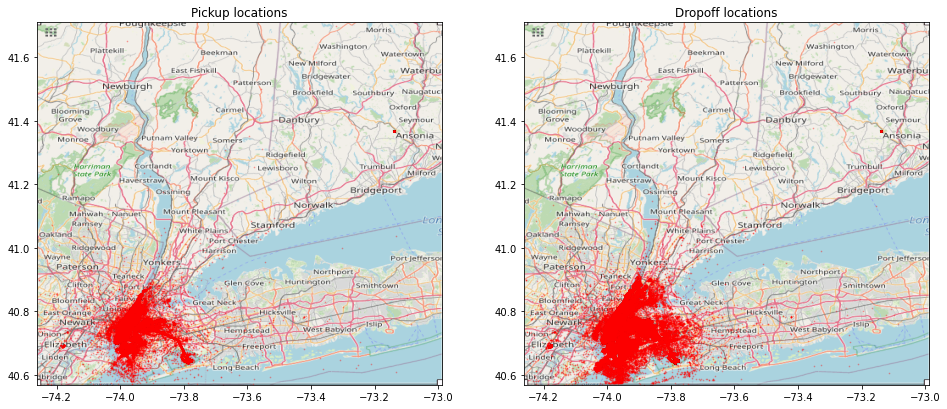

In [ ]:
plot_on_map(df_train, BB, nyc_map, s=0.5, alpha=0.3)

* At the first glance It can be seen, that there is a tendency to travel towards outskirts the downtown;  
* There are some points that are located in the water (maybe it is due to some bugs of the GIS), but they seem to be minor.

C:\Users\faliaksandrovich\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


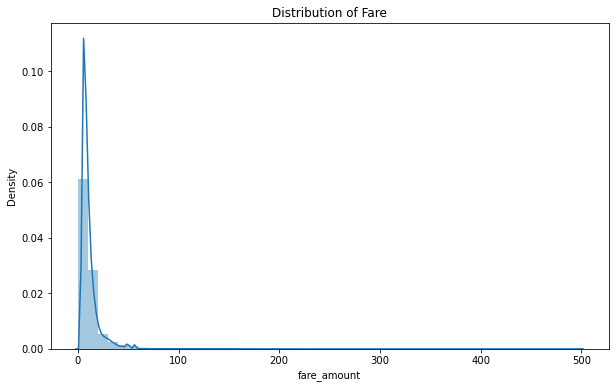

In [ ]:
plt.figure(figsize = (10, 6))
sns.distplot(df_train['fare_amount']);
plt.title('Distribution of Fare');

In [ ]:
top_1 = df_train['fare_amount'].quantile(0.99)
top_1

52.33

The fare price distribution is biased to the right. Hence it is reasonable to exclude the outliers. Based on the rule of thumb one can exlude top 1% numbers: 99% quantile suggests the price of **52 USD**. So the value of **55 USD** is suggested to be the top point.  

In [ ]:
print(f"There are {len(df_train[df_train['fare_amount'] == 0])} $0 fares.")
print(f"There are {len(df_train[df_train['fare_amount'] > 55])} fares greater than $55.")

There are 29 $0 fares.
There are 9307 fares greater than $55.


In [ ]:
df_train = df_train.drop(df_train[df_train['fare_amount']>55].index, axis=0)

Secondly based on the [base fee](https://www.taxi-calculator.com/taxi-rate-new-york-city/259) for day rides (**2.5 USD**) and night rides (**3.00 USD**) one needs also to exclude such orders that have fare prices below these values correspondingly.  
Time horizons are expected to be universally applied, hence this [UK website](https://www.nidirect.gov.uk/articles/taxi-fares) should be fine to reference.

In [ ]:
hour_lst = [int(re.findall(r'\s\d{2}', i)[0]) for i in df_train['key'] ]
df_train['order hour'] = hour_lst

In [ ]:
night_rides = df_train[(~df_train['order hour'].between(6, 20)) & (df_train['fare_amount'] >= 2.5)]
day_rides = df_train[(df_train['order hour'].between(6, 20)) & (df_train['fare_amount'] >= 3)]

In [ ]:
df_train_1 = night_rides.append(day_rides, ignore_index=True)
#assert len(df_train_1) == 0

<ipython-input-34-f83ca0ed9386>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train_1 = night_rides.append(day_rides, ignore_index=True)


C:\Users\faliaksandrovich\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


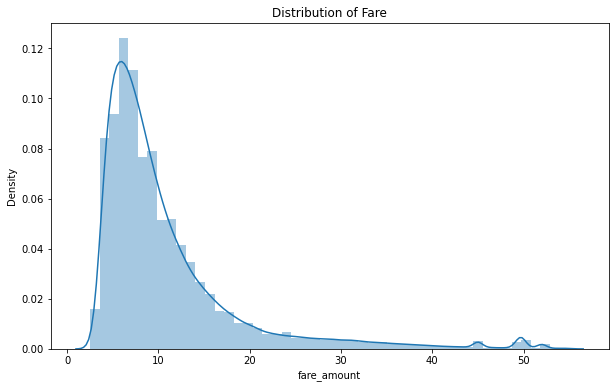

In [ ]:
plt.figure(figsize = (10, 6))
sns.distplot(df_train_1['fare_amount']);
plt.title('Distribution of Fare');

If we started checking the non-reasonable results, let's check the < 1 number of passengers.

In [ ]:
#assert df_train_1[df_train_1['passenger_count'] < 1].shape[0] == 0

Okay, it is classic task about "zemlekops" from the Soviet fairy-tail. But this time one prefers to eclude such observations:

In [ ]:
df_train_1 = df_train_1.drop(df_train_1[df_train_1['passenger_count']<1].index, axis=0)

Text(0, 0.5, 'Count')

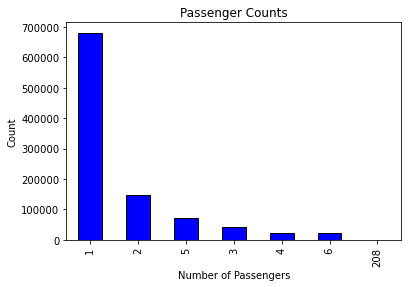

In [ ]:
df_train_1['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k')
plt.title('Passenger Counts')
plt.xlabel('Number of Passengers')
plt.ylabel('Count')

In [ ]:
df_train_1 = df_train_1.drop(df_train_1[df_train_1['passenger_count']>6].index, axis=0)

Now it is time to think about longitude/latitude as variables. These variables as they are does not seem to give any serious insight, as the price for the trip is based on its distance rather than the starting/ending points. Hence, it is needed to create a new column that calculates the trip's distance:

First of all, the Earth is not flat, moreover it is not even a sphere. So, iterative approximations are needed in order to calculate the distance between the points: [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) which assumes Earth to be sphere (~0.5% error) and [Vincenty distance](https://en.wikipedia.org/wiki/Vincenty%27s_formulae) which uses more accurate ellipsoidal models , and is implemented in [`geopy`](https://geopy.readthedocs.io/en/stable/#module-geopy.distance)!

In [ ]:
!pip install geopy

In [ ]:
from geopy import distance

coords_1 = (BB[0], BB[2])
coords_2 = (BB[1], BB[3])

print(distance.geodesic(coords_1, coords_2).km)

146.93422639077937


The above formula is awesome for 1-value input, but we operate with a dataframe. So it is more conveniate to write a simple Haversine formula using numpy functions (thanks to [Stack](https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula)):

In [ ]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

In [ ]:
df_train_1['distance'] = distance(df_train_1.pickup_latitude, df_train_1.pickup_longitude, 
                                  df_train_1.dropoff_latitude, df_train_1.dropoff_longitude)

In [ ]:
df_train_1.groupby('passenger_count')['distance', 'fare_amount'].mean()

<ipython-input-44-6aa6d81fc556>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_train_1.groupby('passenger_count')['distance', 'fare_amount'].mean()


,distance,fare_amount
passenger_count,,
1,17.011502,10.783004
2,15.940061,11.231230
3,16.627052,11.035897
4,21.456337,11.143774
5,12.357772,10.850036
6,25.332554,11.591515


In [ ]:
df_train_1.distance.describe()

count    982522.000000
mean         16.777211
std         335.587350
min           0.000000
25%           1.217859
50%           2.108670
75%           3.823198
max       12594.704725
Name: distance, dtype: float64

In [ ]:
print(df_train_1['distance'].quantile(0.9999))
print('As 99% quantile is equal to ~ 20kms and there is a 12.5k kms outlier it is more than enough to limit the distance to 40kms, \
      but there is a group of observations around 80-100 which after the analysis suggest it to be the trip to the Airport.')

19.63384740248515
As 99% quantile is equal to ~ 20kms and there is a 12.5k kms outlier it is more than enough to limit the distance to 40kms,       but there is a group of observations around 80-100 which after the analysis suggest it to be the trip to the Airport.


Text(0.5, 1.0, 'Histogram ride distances in kms')

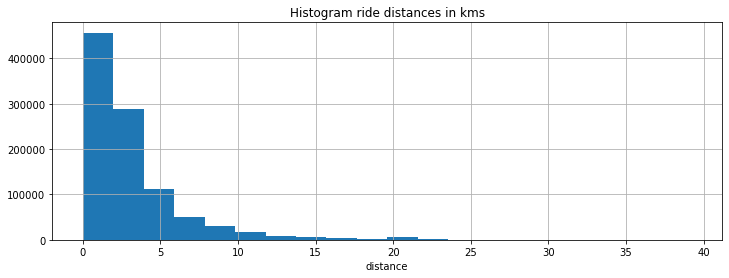

In [ ]:
df_train_1[df_train_1['distance'] < 40].distance.hist(bins=20, figsize=(12,4)) #for the better vidibility 40kms are chosen
plt.xlabel('distance')
plt.title('Histogram ride distances in kms')

In [ ]:
df_train_1 = df_train_1.drop(df_train_1[df_train_1['distance'] > 105].index, axis=0) #exclude outliers fsrther than airports 

Text(0.5, 1.0, 'All data')

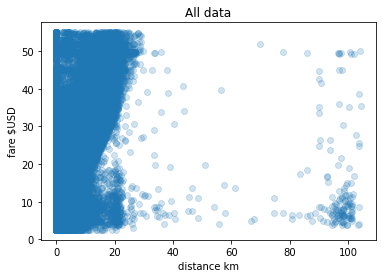

In [ ]:
# scatter plot distance - fare
plt.scatter(df_train_1.distance, df_train_1.fare_amount, alpha=0.2)
plt.xlabel('distance km')
plt.ylabel('fare $USD')
plt.title('All data')

* There are trips with zero distance but with a non-zero fare. Are these 'round' trips? Such trips can be hardly predicted given  only the geometric distance.
* The grouping around 100km might indicate a fixed fare to some distination (Airport or sth).
* Overall there seems to be a (linear) relation between distance and fare with an average rate of **~ 1.75 $USD/km**.

In [ ]:
# remove datapoints with distance < 0.01km (either round or technical trips)
idx = (df_train_1.distance >= 0.01)
print('Old size: %d' % len(df_train_1))
df_train_1 = df_train_1[idx]
print('New size: %d' % len(df_train_1))

Old size: 980682
New size: 952155


NYC map shows, that in the area of JFK airport there are plenty of pickup points, and usually such places have fixed fare. Let's check it visually:

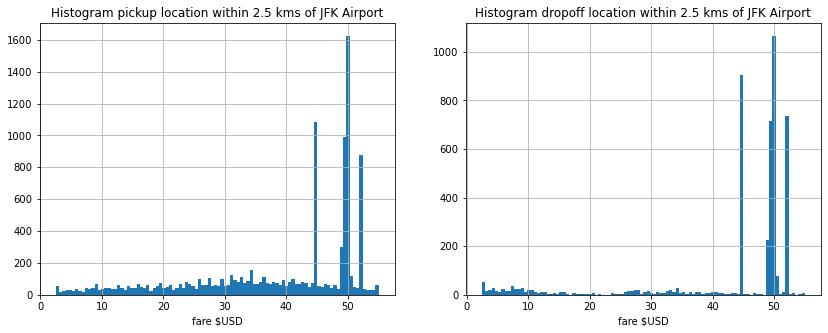

In [ ]:
# JFK airport coordinates, see https://www.travelmath.com/airport/JFK
jfk = (-73.7822222222, 40.6441666667)
nyc = (-74.0063889, 40.7141667)

def plot_location_fare(location, name, range=2.5):
    # select all datapoints with dropoff location within range of airport
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    idx = (distance(df_train_1.pickup_latitude, df_train_1.pickup_longitude, location[1], location[0]) < range)
    df_train_1[idx].fare_amount.hist(bins=100, ax=axs[0])
    axs[0].set_xlabel('fare $USD')
    axs[0].set_title('Histogram pickup location within {} kms of {}'.format(range, name))

    idx = (distance(df_train_1.dropoff_latitude, df_train_1.dropoff_longitude, location[1], location[0]) < range)
    df_train_1[idx].fare_amount.hist(bins=100, ax=axs[1])
    axs[1].set_xlabel('fare $USD')
    axs[1].set_title('Histogram dropoff location within {} kms of {}'.format(range, name));
    
plot_location_fare(jfk, 'JFK Airport')

Yep, it seems clear that the price for the trips from/to JFK airport is fixed and distribted around 50$.

* [open image](https://stackoverflow.com/questions/7391945/how-do-i-read-image-data-from-a-url-in-python)
* [resize image](https://auth0.com/blog/image-processing-in-python-with-pillow/)

Let's check in the same way other NY airports:

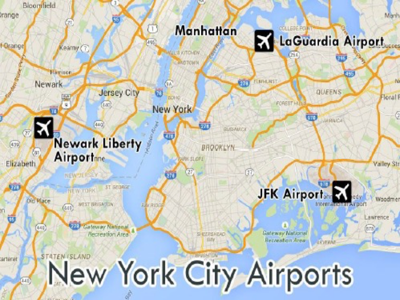

In [ ]:
from PIL import Image
import requests

im = Image.open(requests.get('https://postdocs.weill.cornell.edu/sites/default/files/styles/panopoly_image_original/public/nyc_airports_0.png?itok=9J6jtkQ1',
                             stream=True).raw)
im = im.resize((400, 300))
im

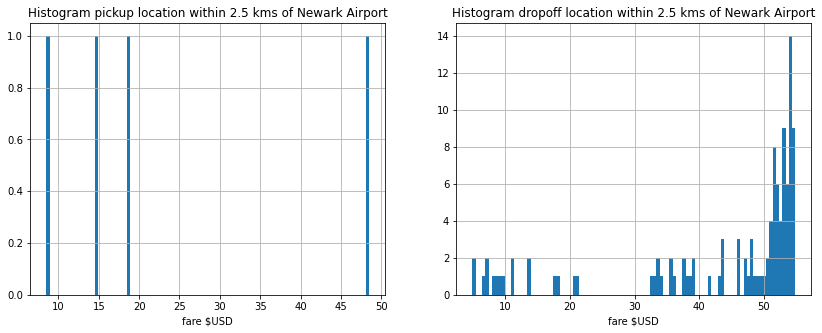

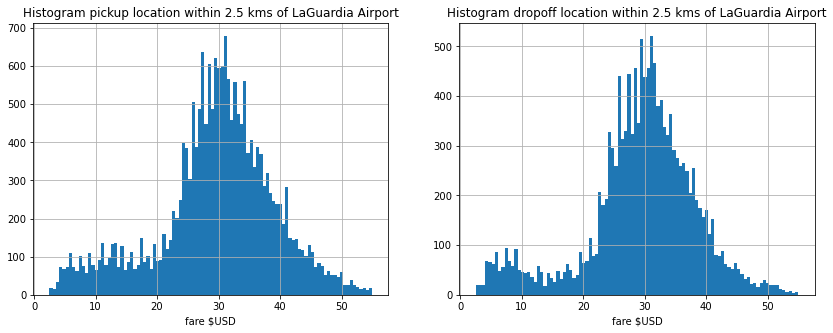

In [ ]:
ewr = (-74.175, 40.69) # Newark Liberty International Airport, see https://www.travelmath.com/airport/EWR
lgr = (-73.87, 40.77) # LaGuardia Airport, see https://www.travelmath.com/airport/LGA
plot_location_fare(ewr, 'Newark Airport')
plot_location_fare(lgr, 'LaGuardia Airport')

Hmm, LaGuardia Airport distribution looks like the normal one with mean of **30 USD**.  
At the same time Newark airport seems to be not very popular destination, but even with the data avaialble one can estimate the ~ fare price: **50 USD**.

In [ ]:
#df_train_1.pickup_datetime[0].hour

### Convertation of the `pickup_datetime` column

In [ ]:
df_train_1['pickup_datetime'] = pd.to_datetime(df_train_1['pickup_datetime'], utc=True)

In [ ]:
df_train_1['year'] = df_train_1.pickup_datetime.apply(lambda t: t.year)
df_train_1['weekday'] = df_train_1.pickup_datetime.apply(lambda t: t.weekday())
df_train_1['hour'] = df_train_1['order hour'] #df_train_1.pickup_datetime.apply(lambda t: t.hour)

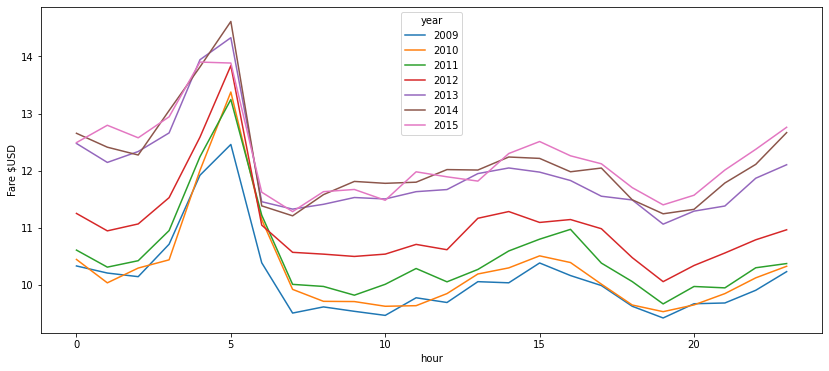

In [ ]:
# display pivot table
df_train_1.pivot_table('fare_amount', index='hour', columns='year').plot(figsize=(14,6))
plt.ylabel('Fare $USD');

From the hour by hour analysis can be seen:  
**1)** In the night-time (8pm-5am) the average fare price is on average higher;  
**2)** There is a spike around 5am (probably those that are clubing till the early morning and can't wait for the subway to open);  
**3)** At the same time there is a gap around 6-7pm suggesting that at this time either go out after the job or simply prefer subway to avoid spending hours in traffic jams;  
**4)** When compared year by year there is a clear positive price trend that probably is related to the inflation finally affecting the price of the taxi ride.

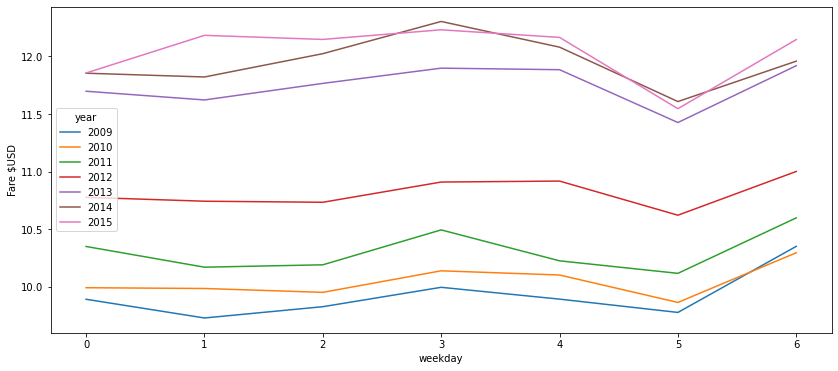

In [ ]:
# display pivot table
df_train_1.pivot_table('fare_amount', index='weekday', columns='year').plot(figsize=(14,6))
plt.ylabel('Fare $USD');

When similar analysis is done for the day of the week no clear tendancies are take place except the decline of price on Saturday when the business activity is not so high and one may prefer a walk or simply stay at home on this day. 

### Clean the test data

In [ ]:
# add new column to dataframe with distance in km
df_test['distance'] = distance(df_test.pickup_latitude, df_test.pickup_longitude, \
                                     df_test.dropoff_latitude, df_test.dropoff_longitude)
#df_test['distance_to_center'] = distance(nyc[1], nyc[0], \
#                                          df_test.dropoff_latitude, df_test.dropoff_longitude)
df_test['hour'] = df_test.pickup_datetime.apply(lambda t: pd.to_datetime(t).hour)
df_test['year'] = df_test.pickup_datetime.apply(lambda t: pd.to_datetime(t).year)

### Model construction

$$ \text{fare} \text{ ~ } \text{year}, \text{hour}, \text{distance}, \text{passenger_count} $$

In [ ]:
features = ['year', 'hour', 'distance', 'passenger_count']
X = df_train_1[features].values
y = df_train_1['fare_amount'].values

In [ ]:
# create training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.metrics import mean_squared_error, explained_variance_score

def plot_prediction_analysis(y, y_pred, figsize=(10,4), title=''):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].scatter(y, y_pred) #obtained values
    mn = min(np.min(y), np.min(y_pred)) #lower bound of y
    mx = max(np.max(y), np.max(y_pred)) #upper bound of y
    axs[0].plot([mn, mx], [mn, mx], c='red') #trend line
    axs[0].set_xlabel('$y$')
    axs[0].set_ylabel('$\hat{y}$')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    evs = explained_variance_score(y, y_pred)
    axs[0].set_title('rmse = {:.2f}, evs = {:.2f}'.format(rmse, evs))
    
    axs[1].hist(y-y_pred, bins=50) #obtained values
    avg = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axs[1].set_xlabel('$y - \hat{y}$')
    axs[1].set_title('Histrogram prediction error, $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(avg, std))
    
    if title!='':
        fig.suptitle(title)

### Linear model

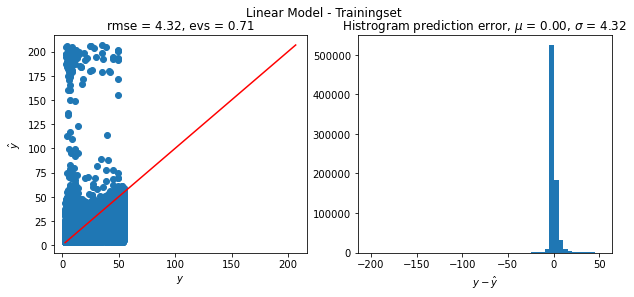

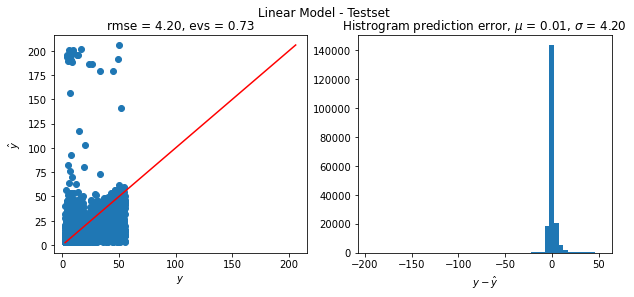

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

model_lin = Pipeline((
        ("standard_scaler", StandardScaler()), #always scale up the values!
        ("lin_reg", LinearRegression()),
    ))
model_lin.fit(X_train, y_train)

y_train_pred = model_lin.predict(X_train)
plot_prediction_analysis(y_train, y_train_pred, title='Linear Model - Trainingset')

y_test_pred = model_lin.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title='Linear Model - Testset')

In [ ]:
from sklearn.metrics import r2_score

print("Train R2: {}".format(round(r2_score(y_train, y_train_pred), 3))) # comparison of the actual answers and predicted ones for train
print("Test R2: {}".format(round(r2_score(y_test, y_test_pred), 3))) # and test samples

Train R2: 0.711
Test R2: 0.726


In [ ]:
filename = './output/baseline_linear'

y_pred_final = model_lin.predict(df_test[features].values)

submission = pd.DataFrame(
    {'key': df_test.key, 'fare_amount': y_pred_final},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)

### + Manhattan distance

In [ ]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)
# if p = 1, then this is the Manhattan distance and if p = 2 this is the Euclidean distance.

In [ ]:
df_train_1['distance_manhattan'] = minkowski_distance(df_train_1.pickup_latitude, df_train_1.pickup_longitude, 
                                  df_train_1.dropoff_latitude, df_train_1.dropoff_longitude, 1)

In [ ]:
df_train_1.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,order hour,distance,year,weekday,hour,distance_manhattan
0,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,1.389525,2011,3,0,229.485812
1,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,2.799270,2012,5,4,229.469932
2,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00+00:00,-73.980658,40.733873,-73.991540,40.758138,2,1,2.849627,2009,2,1,229.464209
3,2009-11-06 01:04:03.0000002,4.1,2009-11-06 01:04:03+00:00,-73.991601,40.744712,-73.983081,40.744682,2,1,0.717767,2009,4,1,229.464076
4,2013-08-11 00:52:00.00000026,4.5,2013-08-11 00:52:00+00:00,-73.981020,40.737760,-73.980668,40.730497,2,0,0.808153,2013,6,0,229.429945


In [ ]:
features = ['year', 'hour', 'distance_manhattan', 'passenger_count']
X_m = df_train_1[features].values
y_m = df_train_1['fare_amount'].values

In [ ]:
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_m, y_m, test_size=0.2)

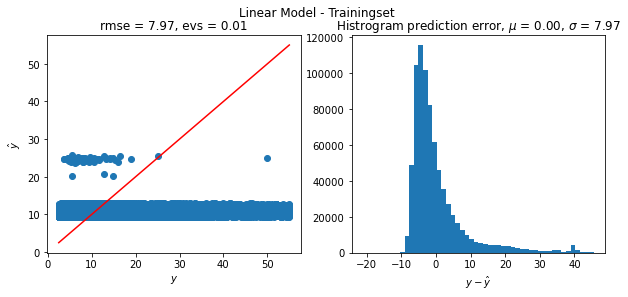

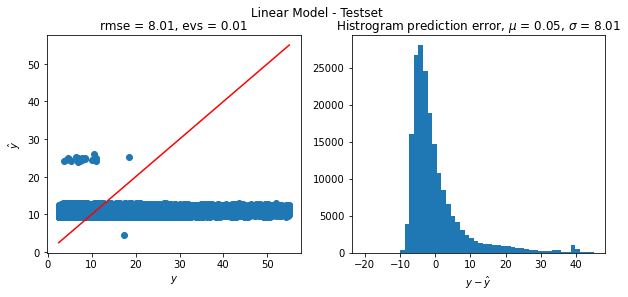

In [ ]:
model_lin.fit(X_m_train, y_m_train)

y_m_train_pred = model_lin.predict(X_m_train)
plot_prediction_analysis(y_m_train, y_m_train_pred, title='Linear Model - Trainingset')

y_m_test_pred = model_lin.predict(X_m_test)
plot_prediction_analysis(y_m_test, y_m_test_pred, title='Linear Model - Testset')

In [ ]:
print("Train R2: {}".format(round(r2_score(y_m_train, y_m_train_pred), 3))) # comparison of the actual answers and predicted ones for train
print("Test R2: {}".format(round(r2_score(y_m_test, y_m_test_pred), 3))) # and test samples

Train R2: 0.011
Test R2: 0.011


The result seem to be extremly poor (low $R^2$ and long tails of residuals), as Manhattan where such formula suits good represents a relatively small area, hence the usage of Manhattan distance is not reasonable.